# 1. Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
import mediapipe as mp
import pandas as pd

from matplotlib import pyplot as plt

# 2. Keypoints using MP Holistic

importiamo il modello Holistic di MediaPipe

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_hands = mp.solutions.hands # Hands model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp_drawing_styles = mp.solutions.drawing_styles

funzione di riconoscimento: convertiamo prima l'immagine dal canale BGR (output di OpenCV feed) a quello RGB, necessario per MediaPipe;
alla fine riconvertiamo in BGR

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction with the Holistic model
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

ora visualizziamo i landmark graficamente, in maniera standard; li renderizziamo -> saranno visibili a schermo

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

#le X_CONNECTIONS sono mappe che restituiscono i legami fra i vari landmark

formattiamo, personalizziamo i landmark in maniera grafica

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             #mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             #mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             #) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# 3. Extract Keypoint Function

restituisce il numero dei landmark usati per la parte del corpo specificata

Lavoriamo su ciascun landkmark: 

- creiamo degli array dove memorizzare le sue coordinate (dei landmark)

- Useremo degli array di zero quando una certa parte del corpo non è riconosciuta/presente, per non fare andare in errore il sistema.

Facciamo la stessa cosa, ma tutto su una sola linea.

**N.B.** usiamo *flatten()* perchè vogliamo un solo array, unidimensionale, perchè ci servirà questo formato per la LSTM; infatti, senza flatten() avremo una matrice, un array bidimensionale (ciascun landmark avrà *x* valori associati)

come abbiamo detto prima, creiamo un array vuoto (di zeri), per gestire l'errore nel caso in cui una parte del corpo non è riconosciuta.

qui facciamo quello fatto sopra, ma in maniera pù organizzata, in una funzione apposita:

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

nello specifico:

res.x, res.y, res.z sono i singoli valori delle coord. per ciascun landmark, che verranno inseriti in un array più grande, ciclando per ogni landmark:

- se non esistono coordinate per i landmark, quindi quella parte del corpo non è riconosciuta, viene creato un array vuoto

### abbiamo estratto i **keypoints** per il frame di interesse, che saranno utili per il riconoscimento dei gesti/segni

# 4. Setup Folders

quali sono i gesti contenuti nel dataset?

In [9]:
labels_file = pd.read_csv(r'D:\TMS\dataset\jester\labels\labels.csv') #TODO rel path

gestures = labels_file['labels'].tolist() #metto in una lista tutte le labels del dataset
gestures_array = np.array(gestures)

memorizzo la lista di tutti i video disponibili sulla macchina

In [ ]:
DATADIR = r'D:\TMS\dataset\jester\20bn-jester-v1'

list_video = sorted(os.listdir(DATADIR), key=len) #li voglio ordinati così come compaiono nell'explorer dei file

In [8]:
list_video_int = list(map(int, list_video)) #converto tutto in int da string
len(list_video_int)

37793

#### abbiamo **37793** video sulla macchina, perchè non ancora estratti tutti (148k)

elimino tutti i keypoints estratti con Holistic

In [108]:
import glob

DATADIR = r"D:\TMS\dataset\jester\20bn-jester-v1"
os.chdir(DATADIR)

pattern = "*.npy"

for vid in list_video: #per ogni video
    path = os.path.join(DATADIR, str(vid), "keypoints")
    os.chdir(path)
    arrays = glob.glob(pattern)

    for file in arrays:
        os.remove(file)          

creo fold in cui salvare keypoints, per ogni video

In [15]:
for vid in list_video: #per ogni video
        try: 
            os.makedirs(os.path.join(DATADIR, str(vid), "keypoints"))
        except:
            pass #se esistono già, skippa la creazione

creo ora folds dei gesti, dove salvaremo ogni video in cui la stessa è performata

In [10]:
jester_gestures = np.array(["Stop Sign", "Thumb Down", "Thumb Up"]) #sono le azioni che mi interessano in questo dataset

In [ ]:
for label in jester_gestures: #per ogni label (per ogni gesto)
    try:
        os.makedirs(os.path.join(DATADIR, label))
    except:
        pass #se esistono già, skippa la creazione

# 5. Collect Keypoint Values from the dataset for Training and Testing

❗❗ Estrarremo i keypoints dai frame di ciascun video presente nel **dataset** *Jester*

Struttura del dataset Jester:

- **VIDEO:** 148092
    - **FRAME x video:** circa 30
        - *FPS:* 12, un frame ogni 12 s
        - *altezza:* 100px
        - *larghezza:* variabile

Il dataset, contenente **148092** video, è inoltre già splittato negli insiemi di **Training, Test e Validation:**

- **TRAINING** videos: 118562 
- **TEST** videos: 14743 
- **VALIDATION** videos: 14787 

Il dataset conterrà **27** labels (classi) di gesti diversi, ma noi siamo interessati solamente alle seguenti **3**:
- **Thumb Up**
- **Thumb down**
- **Stop Sign**

otteniamo i video per il **training** del modello:

In [11]:
train_file = pd.read_csv(r'D:\TMS\dataset\jester\labels\train.csv', delimiter=";") #TODO path relativo
train_list = train_file['key'].tolist() #lista degli indici dei video attualmente estratti
train_file

,key,value
0,34870,Drumming Fingers
1,56557,Sliding Two Fingers Right
2,129112,Sliding Two Fingers Down
3,63861,Pulling Two Fingers In
4,131717,Sliding Two Fingers Up
...,...,...
118557,75507,Swiping Down
118558,48433,Sliding Two Fingers Left
118559,146421,Sliding Two Fingers Right
118560,49514,Thumb Up


i video di training, come visto sopra, per l'intero dataset sono **118'562** su **148'092**.

otteniamo ora i video per il **testing** del modello:

In [12]:
test_file = pd.read_csv(r'D:\TMS\dataset\jester\labels\test-answers.csv', delimiter=";") #TODO path relativo
test_list = test_file['key'].tolist() #lista degli indici dei video attualmente estratti
test_file = test_file.loc[:, ~test_file.columns.str.contains('^Unnamed')]  #cancello colonne non necessarie
test_file

,key,value
0,115190,Turning Hand Counterclockwise
1,49340,Turning Hand Clockwise
2,118693,Shaking Hand
3,141855,Pulling Hand In
4,138995,Thumb Down
...,...,...
14738,82713,Swiping Up
14739,129898,Zooming Out With Two Fingers
14740,86265,Swiping Right
14741,140844,Zooming Out With Full Hand


come ancora visto sopra, per l'intero dataset abbiamo **14743** video di test

------------------------------------------------------------------------------------

### MA, come detto prima, del dataset **JESTER** mi interessano esclusivamente *TRE* azioni, definite prima:

- **Thumb Up**
- **Thumb Down**
- **Stop Sign**

#### **FILTRIAMO** ora da tutti i video del dataset, ottenendo un dataframe contenente solamente i video di interesse 

In [13]:
train_file = train_file.query("value in @jester_gestures") #13100 video
test_file = test_file.query("value in @jester_gestures") #1619 video

In [11]:
train_file

,key,value
7,136859,Thumb Up
10,60572,Stop Sign
14,42237,Thumb Down
22,94060,Thumb Down
34,14506,Stop Sign
...,...,...
118525,78845,Thumb Up
118528,99153,Thumb Up
118544,43396,Thumb Down
118556,99358,Stop Sign


In [12]:
test_file

,key,value
4,138995,Thumb Down
24,39311,Thumb Down
31,20922,Stop Sign
36,70814,Thumb Up
40,109447,Stop Sign
...,...,...
14687,126742,Stop Sign
14702,45706,Thumb Up
14726,9936,Thumb Up
14731,131876,Thumb Down


#### abbiamo quindi **13100** video di **training** e **1619** di **test**, che contengono i gesti da noi scelti, sull'intero dataset 

In [14]:
my_total_videos = train_file["key"].tolist() + test_file["key"].tolist()
len(my_total_videos)

14719

#### in totale abbiamo dunque **14719** video che contengono i gesti di nostro interesse, sui 148'092 del dataset (*10%*)

------------------------------------------------------------------------------------

### **N.B.** Vediamo ora come selezionare i frame dal dataset scelto, già estratti dai video

------------------------------------------------------------------------------------

#### *prima però bisogna considerare che non ho estratto dall'archivio .**tar** tutti i video ...*
- ##### a questo proposito, **filtro** ancora, selezionando solo i video attualmente disponibili sulla macchina

- vediamo prima il **training set**

In [ ]:
my_train_list = [] #lista che contiene i miei video di training, attualmente disponibili

for vid in list_video_int:
    for train_vid in train_list:
        if vid == train_vid:                
            my_train_list.append(vid)

In [15]:
BASEDIR = r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics"

In [ ]:
np.save(os.path.join(BASEDIR, "mytempfiles", "mytrainlist"), my_train_list)

In [16]:
my_train_list = np.load(os.path.join(BASEDIR, "mytempfiles", "mytrainlist.npy")).tolist() #30000 video di training totali su 37k
len(my_train_list)

30228

attualmente, considerando solamente le *tre label* citate sopra, abbiamo **3247** video di training sui **30228** disponibili, sui **37793** totali

In [17]:
my_train_file = train_file.query('key in @my_train_list') #sottoinsieme di train_file, che contiene solo i video di training attualm. disponibili
my_train_list2 = sorted(my_train_file['key'].tolist())  #lista degli indici dei video di training attualmente disponibili

len(my_train_list2)

3247

- facciamo lo stesso per il **test set**

In [18]:
my_test_list = [] #lista che contiene i miei video di test, attualmente disponibili

#mostra tutti gli indici dei video attualmente estratti dall'archivio tar, convertiti in integers
list_video_int = list(map(int, list_video))

for vid in list_video_int:
    for test_vid in test_list:
        if vid == test_vid:               
            my_test_list.append(vid)

NameError: name 'list_video' is not defined

In [40]:
np.save(os.path.join(BASEDIR, "mytempfiles", "mytestlist"), my_test_list)

In [19]:
my_test_list = np.load(os.path.join(BASEDIR, "mytempfiles", "mytestlist.npy")).tolist() #3767 video di test totali su 37k

In [20]:
my_test_file = test_file.query('key in @my_test_list') #sottoinsieme di test_file, che contiene solo i video di testing attualm. disponibili
my_test_list2 = sorted(my_test_file['key'].tolist())  #lista degli indici dei video di testing attualmente disponibili

my_test_file

,key,value
4,138995,Thumb Down
61,24811,Thumb Up
67,11203,Thumb Down
112,65131,Thumb Up
168,18313,Thumb Down
...,...,...
14553,132907,Thumb Up
14590,113560,Thumb Down
14610,19857,Thumb Down
14702,45706,Thumb Up


attualmente abbiamo **408** video di test su **37793** totali, considerando il filtraggio per le tre label

In [20]:
my_actual_videos = my_train_file["key"].tolist() + my_test_file["key"].tolist()
len(my_actual_videos)

3655

in totale abbiamo quindi **3655** video disponibili, divisi fra train e test

----------------------------------------------------------------------------------------------------------------------------------------------------

### Genero nuovi frame per ogni video se esso non raggiunge i 30 frame, copiandone l'ultimo, ripetutamente

In [23]:
def get_num_frames(path):   

    # restituisce tutti gli elementi nel path indicato, nel nostro caso tutti i frame per il video specificato con il suo path
    frames_4_video = os.listdir(path)        
    num_frames = len(frames_4_video) - 1 #togliamo 1 perchè non consideriamo la fold dei keypoints
    print("Numero frame per questo video:", num_frames)

    return num_frames

In [24]:
def get_last_frame(path):

    frames_4_video = os.listdir(path)
    last_frame = frames_4_video[-2] #prendiamo l'ultimo frame
    print("\nnome ultimo frame:", last_frame)
    img_path = os.path.join(path, last_frame)
    img_array = cv2.imread(img_path) 

    return last_frame, img_array

In [25]:
def create_name_frame(last_frame):
    num_frame = last_frame[3:5] #prendo solamente i char 3, 4 perchè mi interessa il numero del frame
    num_frame = int(num_frame) + 1
    last_frame = "000" + str(num_frame) + ".jpg"
    return last_frame

#### **TODO**: aggiungere non solo ripetutamente l'ultimo frame, ma gli ultimi/primi 3, 4, 5 ...

In [ ]:
DATADIR = r'D:\TMS\dataset\jester\20bn-jester-v1'
TRESHOLD = 30

for vid in list_video_int:

    path = os.path.join(DATADIR, str(vid))  
    os.chdir(path)  

    num_frames = get_num_frames(path)    

    if num_frames < TRESHOLD:
        
        print("Percorso video:", path)
        print("\nNumero frame per questo video:", num_frames)
        
        while num_frames < TRESHOLD:

            last_frame, img_array = get_last_frame(path)
            last_frame = create_name_frame(last_frame)                    
            cv2.imwrite(last_frame, img_array) #salvo nella fold il "nuovo" frame, ovvero una copia dell'ultimo frame

            num_frames += 1
            print("numero frame aggiornato:", num_frames) 
    else:
        print("il video ha già almeno 30 frame")       
    

- ### accedo ai frame di ogni video e ne estraggo i keypoints

estraggo e memorizzo i keypoints

In [26]:
def detect_and_extract(img_array, model):    
    
    image, results = mediapipe_detection(img_array, model)                   
    keypoints = extract_keypoints(results)
    return keypoints

inizializzazione liste

In [107]:
DATADIR = r'D:\TMS\dataset\jester\20bn-jester-v1'
os.chdir(DATADIR)

actual_train_video = []
actual_test_video = []
actual_video = []

In [28]:
def get_num_keypoints(path):
    keypoints_path = os.path.join(path, 'keypoints')
    num_keypoints = len(os.listdir(keypoints_path)) #indica quanti keypoints sono stati estratti 
    
    return num_keypoints 

In [29]:
def get_and_append_img(path, img, all_frames):

    img_num = img[0:5] #prendo i primi N char, per non avere l'estensione nel nome quando salvo dopo
    img_path = os.path.join(path, img)
    img_array = cv2.imread(img_path)  # convert to array
    print(img_path)                    
    all_frames.append(img)

    return img_array, img_num

In [23]:
len(my_train_list2)

3247

In [31]:
def access_frames(list, actual_video_type):

    with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:

        for vid in list:  # itero su tutti i video (i primi 1500)...

            all_frames = []

            # create path (...\20bn-jester-v1\000xx)
            path = os.path.join(DATADIR, str(vid))
            print("\nPercorso video:", path)

            frames_4_video = os.listdir(path)
          
            num_frames = get_num_frames(path)        
            num_keypoints = get_num_keypoints(path) #indica quanti keypoints sono stati estratti   
            
            # esegui se non tutti i keypoints sono stati ancora estratti da ciascun frame 
            if num_keypoints != num_frames:            
                
                # iterate over each image (00001, 00002, ...)
                for img in frames_4_video:            
                            
                    if not img == 'keypoints': #non considero la cartella dove salvo i keypoints (TODO potrei farlo prima, escludendo la cartella)
                                        
                        img_array, img_num = get_and_append_img(path, img, all_frames)

                        keypoints = detect_and_extract(img_array, holistic)

                        # salvo i keypoints su disco
                        npy_path = os.path.join(DATADIR, str(vid), "keypoints", img_num)
                        np.save(npy_path, keypoints)
                
            else:
                print("N.B. keypoints già estratti per questo video")
                actual_video_type.append(vid)
                actual_video.append(vid)

In [ ]:
access_frames(my_train_list2, actual_train_video) #accedo ai frame dei video di train..
access_frames(my_test_list2, actual_test_video) #.. e per quelli di test

In [113]:
np.save("actualvideo", actual_video)
np.save("actual_test_video", actual_test_video)
np.save("actual_train_video", actual_train_video)

In [21]:
actual_video = np.load(os.path.join(BASEDIR, "mytempfiles", "actualvideo.npy"))
actual_train_video = np.load(os.path.join(BASEDIR, "mytempfiles", "actual_train_video.npy"))
actual_test_video = np.load(os.path.join(BASEDIR, "mytempfiles", "actual_test_video.npy"))

In [19]:
print(len(actual_video))
print(len(actual_train_video))
print(len(actual_test_video))

3655
3247
408


ho quindi a disposizione **3655** video totali per il momento

- opero altra suddivisione per **TRAINING SET** ottenendo il file su cui **addestrare il modello**

In [22]:
my_train_file2 = my_train_file.query('key in @actual_train_video') #contiene indice e label dell'azione associata a quel video
my_train_file2.sort_values(["key"], axis=0, ascending=[True], inplace=True) #ordino gli elem in modo crescente in base al valore dell'idx del video 

#my_train_file2 #questo è il file su cui devo lavorare come training set

abbiamo dunque **3247** video di training su cui addestrare il modello

- facciamo lo stesso per i video di **TEST**:

In [23]:
my_test_file2 = my_test_file.query('key in @actual_test_video') #contiene indice e label dell'azione associata a quel video
my_test_file2.sort_values(["key"], axis=0, ascending=[True], inplace=True) #ordino gli elem in modo crescente in base al valore dell'idx del video 

#my_test_file2 #questo è il file su cui devo lavorare come training set

ho **408** video di test al momento su cui testare il modello

----------------------------------------------------------------------------------------------------

vedo quali sono le azioni presenti nei video disponibili, per l'insieme di **train** e **test**:

- conto le occorrenze di ogni gesto in questi insiemi (*quanti ce ne sono per ...*)

In [22]:
print(my_train_file2["value"].value_counts())
print(my_test_file2["value"].value_counts())

Thumb Up      1108
Thumb Down    1092
Stop Sign     1047
Name: value, dtype: int64
Stop Sign     139
Thumb Up      136
Thumb Down    133
Name: value, dtype: int64


----------------------------------------------------------------------------------------------------------------------------

#### **TEST 2:** prendo una precisa immagine dal dataset

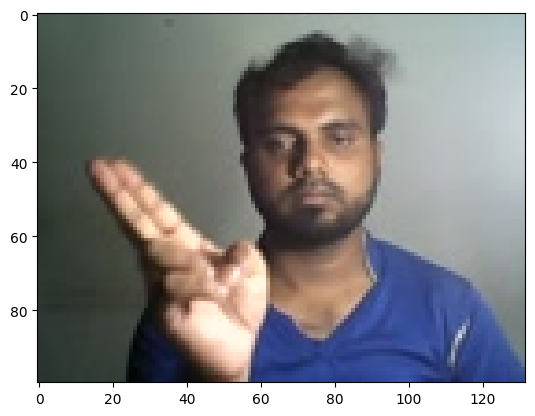

In [8]:
DATADIR2 = r'D:\TMS\dataset\jester\20bn-jester-v1\51413'

# OTTENGO I FRAME    
path = os.path.join(DATADIR2, '00024.jpg')  # create path (...\Color\rgb1)
frame = cv2.imread(path)  # convert to array
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))      

- provo con modello *Holistic*

<class 'mediapipe.python.solution_base.SolutionOutputs'>
[ 5.60796142e-01  4.14329886e-01 -1.28200638e+00  9.99946356e-01
  5.99057496e-01  3.43617439e-01 -1.18875778e+00  9.99914289e-01
  6.19484961e-01  3.42422843e-01 -1.18915045e+00  9.99893665e-01
  6.36109352e-01  3.44029307e-01 -1.18905234e+00  9.99872565e-01
  5.31443357e-01  3.46562266e-01 -1.18514776e+00  9.99917507e-01
  5.09395063e-01  3.47949982e-01 -1.18473148e+00  9.99928832e-01
  4.88524467e-01  3.51379037e-01 -1.18505776e+00  9.99930024e-01
  6.73818529e-01  3.75451803e-01 -5.84402561e-01  9.99888062e-01
  4.76699859e-01  3.83767635e-01 -5.44300556e-01  9.99927640e-01
  6.04315102e-01  4.88298416e-01 -1.06224823e+00  9.99946237e-01
  5.21191716e-01  4.96409059e-01 -1.05244672e+00  9.99927044e-01
  8.39295030e-01  8.02396595e-01 -2.83169419e-01  9.92431045e-01
  3.44488651e-01  7.55486131e-01 -4.28559035e-01  9.97290492e-01
  9.79300737e-01  1.27809167e+00 -5.32055140e-01  1.12281121e-01
  2.93049932e-01  1.23004460e+00 

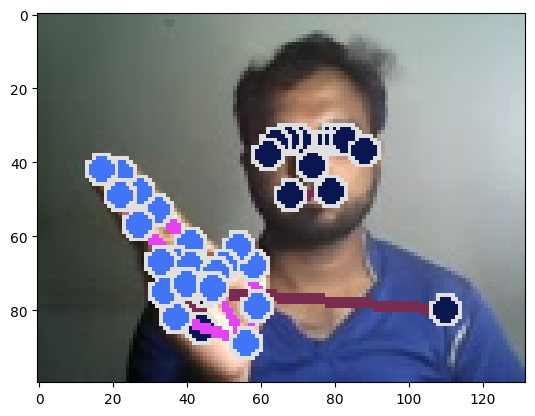

In [10]:
# ESTRAGGO I KEYPOINTS DA UN FRAME
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    image, results = mediapipe_detection(frame, holistic)
    draw_styled_landmarks(image, results)
    print(results)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  

    keypoints = extract_keypoints(results) #memorizzo i keypoints estratti
    print(keypoints)    

In [ ]:
keypoints

In [123]:
keypoints.shape    

(258,)

abbiamo **258** keypoints per ogni frame

- provo solamente con modello *Hands*

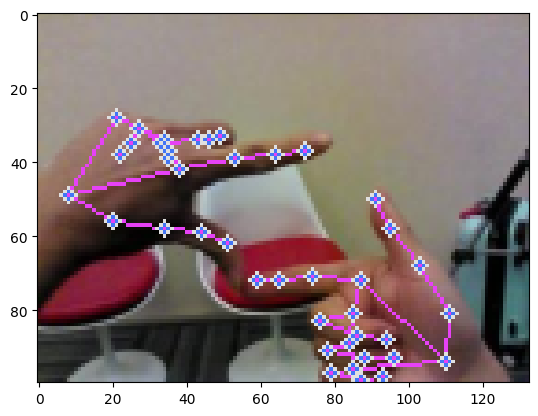

In [18]:
# ESTRAGGO I KEYPOINTS DA CIASCUN FRAME
with mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5) as hands:
    image_h, results = mediapipe_detection(frame, hands)
    
    annotated_image = image_h.copy()
    
    for hand_landmarks in results.multi_hand_landmarks:        

        mp_drawing.draw_landmarks(     
            annotated_image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
            )
               
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))   

# 6. Preprocess Data and Create Labels and Features

In [24]:
#from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

strutturiamo i dati fin ora raccolti, inserendoli in un unico array

qui cicliamo separatamente per i video di training e test, avendoli già divisi:

In [129]:
def insert_all_in_array(actual_video_type):

    videos_type = []

    for vid in actual_video_type: 

        window_type = [] #rappresenta un unico video: insieme di X frame

        #num_frames = len(os.listdir(os.path.join(DATADIR, str(vid))))
        #print(num_frames)

        for frame_num in range(1, 31): #range(1, num_frames): #itero per tutti i frame estratti per quel video        
            #faccio if perchè gli array dei keypoint sono salvati come '000xx.npy' e non come 'x.npy'-> #TODO rinominarli
            if frame_num < 10:
                res = np.load(os.path.join(DATADIR, str(vid), "keypoints", "0000{}.npy".format(frame_num)))
                window_type.append(res)
            else:
                res = np.load(os.path.join(DATADIR, str(vid), "keypoints", "000{}.npy".format(frame_num)))
                window_type.append(res)

        videos_type.append(window_type)    
        #labels.append(label_map[action]) #TODO come associare la label a ogni video??
        # array monodimensionale (ci dice per ogni video quale azione è presente al suo interno: la prima, ... -> definizione di LABEL)

    return videos_type, window_type

In [131]:
train_videos, train_window = insert_all_in_array(actual_train_video)
test_videos, test_window = insert_all_in_array(actual_test_video)

In [132]:
np.save(os.path.join(BASEDIR, "mytempfiles", "test_videos"), test_videos)
np.save(os.path.join(BASEDIR, "mytempfiles", "train_videos"), train_videos)

In [25]:
train_videos = np.load(os.path.join(BASEDIR, "mytempfiles", "train_videos.npy"))
test_videos = np.load(os.path.join(BASEDIR, "mytempfiles","test_videos.npy"))

In [26]:
print(np.array(train_videos).shape)
print(np.array(test_videos).shape)
#print(np.array(train_window).shape)
#print(np.array(test_window).shape)

(3247, 30, 258)
(408, 30, 258)


In [27]:
X_train = np.array(train_videos)
X_test = np.array(test_videos)

In [ ]:
X_train

In [26]:
X_train.shape

(3247, 30, 258)

In [28]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label_train = le.fit_transform(my_train_file2['value']) 
label_test = le.fit_transform(my_test_file2['value'])

In [ ]:
label_train

vedo come si sono trasformati i valori categorici in numerici per ongi video

In [29]:
my_train_file3 = my_train_file2.copy()
my_train_file3.drop("value", axis=1, inplace=True)

my_train_file3["value"] = label_train
 
# printing Dataframe
my_train_file3

,key,value
106437,10,1
81135,48,1
18377,59,0
76680,105,0
114606,145,0
...,...,...
104078,147835,0
24536,147882,1
52677,147921,0
112351,148029,0


In [30]:
my_test_file3 = my_test_file2.copy()
my_test_file3.drop("value", axis=1, inplace=True)

my_test_file3["value"] = label_test
 
# printing Dataframe
my_test_file3

,key,value
12493,390,1
10315,832,2
8823,870,0
11242,1305,0
4020,1911,2
...,...,...
11136,145410,1
9178,145440,0
395,146024,2
6052,146961,0


In [31]:
label_train = np.array(my_train_file3["value"]).tolist()
#label_train

In [32]:
label_test = np.array(my_test_file3["value"]).tolist()
#label_test

trasformo feature categoriche in feature numeriche (One Hot Encoding)

In [33]:
y_train = to_categorical(label_train).astype(int)
y_test = to_categorical(label_test).astype(int)

In [33]:
print(y_train.shape)
print(y_test.shape) # 3 sono le classi

(3247, 3)
(408, 3)


# 7. Build and Train LSTM Neural Network

Addestriamo la rete neurale (ricorrente) **LSTM**: 

- perchè usare MediaPipe Holistic + una rete neurale LSTM?
    - occorrono *meno dati*
    - più *veloce* nell'addestramento
    - riconoscimento più *veloce* <- RN più *semplice*

In [34]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
from keras.layers import Dropout

**TensorBoard** ci offre una web app per monitorare il nostro modello: addestramento, accuratezza, ... 

In [148]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [35]:
jester_gestures = np.array(["Stop Sign", "Thumb Down", "Thumb up"])
jester_gestures.shape[0]

3

In [35]:
# il modello Sequential ci permette di aggiungere layer in mainera organizzata e facile
model = Sequential()

#tre layer LSTM
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape = (30, 258))) #64 unità
model.add(LSTM(128, return_sequences=True, activation='relu')) #return_sequences è necessario per il passaggio di dati al layer successivo
model.add(LSTM(64, return_sequences=False, activation='relu'))

#droppiamo casualmente dei nodi
model.add(Dropout(0.5))

#tre layer Dense
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(jester_gestures.shape[0], activation='softmax')) #distribuzione di probabilità che assegna ad ogni azione una certa prob.

Compiliamo il modello, usando:

- loss function: "categorical cross entropy"
    - è obbligatoria per classificazione multi-classe

In [39]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [155]:
model_temp = model.fit(X_train, y_train, epochs = 100, callbacks=[tb_callback])

Epoch 1/100
102/102 [==============================] - 27s 116ms/step - loss: 1.0440 - categorical_accuracy: 0.4731
Epoch 2/100
102/102 [==============================] - 12s 115ms/step - loss: 0.9696 - categorical_accuracy: 0.4823
Epoch 3/100
102/102 [==============================] - 11s 110ms/step - loss: 1.0339 - categorical_accuracy: 0.4909
Epoch 4/100
102/102 [==============================] - 11s 111ms/step - loss: 0.8375 - categorical_accuracy: 0.6384
Epoch 5/100
102/102 [==============================] - 12s 113ms/step - loss: 7.3279 - categorical_accuracy: 0.5645
Epoch 6/100
102/102 [==============================] - 12s 113ms/step - loss: 0.8108 - categorical_accuracy: 0.6298
Epoch 7/100
102/102 [==============================] - 11s 111ms/step - loss: 0.5483 - categorical_accuracy: 0.7856
Epoch 8/100
102/102 [==============================] - 11s 112ms/step - loss: 0.3964 - categorical_accuracy: 0.8500
Epoch 9/100
102/102 [==============================] - 12s 113ms/step - 

In [156]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            82688     
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                

# 8. Make Predictions

In [37]:
res = model.predict(X_test) #prendo tutte le predizioni dall'insieme di test
# res[0]: significa che prendo la prima prediction (quindi la prediction della prima azione presente in X_test)

13/13 [==============================] - 2s 42ms/step


poichè ad ogni azione è associata una probabilità, la mia predizione sarà quella che avrà probabilità **maggiore** fra esse

In [41]:
jester_gestures[np.argmax(res[2])] #qual'è l'azione con il più altro valore di probabilità associato?

'Stop Sign'

prendo la label della 4a azione: vedo quindi il *ground truth*

In [42]:
jester_gestures[np.argmax(y_test[2])]

'Stop Sign'

ovviamente, se le due azioni **coincidono** significa che il modello ha una **buona accuracy**

# 9. Save Weights

In [265]:
model.save('action2.h5')

In [ ]:
del model

In [36]:
model.load_weights(os.path.join(BASEDIR, "models_action", "action2.h5"))

# 10. Evaluation using Confusion Matrix and Accuracy

In [38]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [39]:
yhat = model.predict(X_test)

13/13 [==============================] - 1s 37ms/step


In [40]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [62]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[269,   0],
        [  8, 131]],

       [[275,   0],
        [ 10, 123]],

       [[254,  18],
        [  0, 136]]], dtype=int64)

In [41]:
accuracy_score(ytrue, yhat)

0.9558823529411765

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

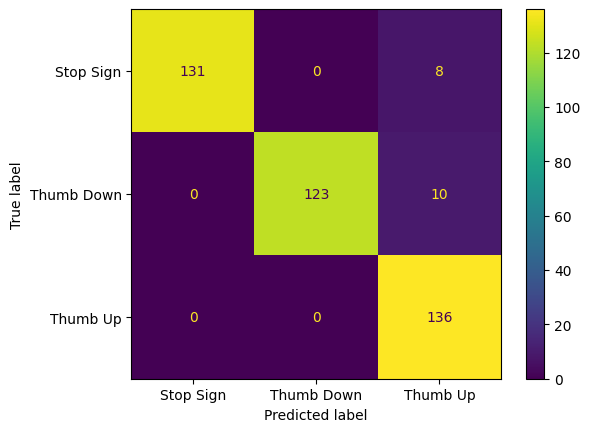

In [43]:
ConfusionMatrixDisplay.from_predictions(jester_gestures[ytrue], jester_gestures[yhat])

# 11. Test in Real Time

In [41]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, jester_gestures, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, jester_gestures[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [42]:
res.shape

(408, 3)

In [44]:
# 1. New detection variables
sequence = []
predictions = []
gesto = ""
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(jester_gestures[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): #cambia gesto solo se gli ultimi 10 frame sono diversi
                if res[np.argmax(res)] > threshold:                     
                    gesto = jester_gestures[np.argmax(res)]
             
            # Viz probabilities
            image = prob_viz(res, jester_gestures, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(gesto), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti